In [1]:
import pandas as pd
import numpy as np

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import RFE

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

from tqdm import tqdm

C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_model_comparison = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\prediction_interval_comparison_data.h5',key="df")

Running on PyMC3 v3.11.2


C:\Python\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, random_forest_std, no_gpu_std, gpu_std, random_forest_mean, no_gpu_mean, gpu_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Python\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


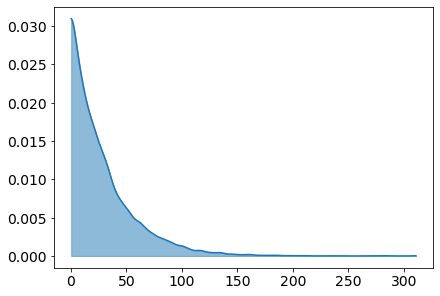

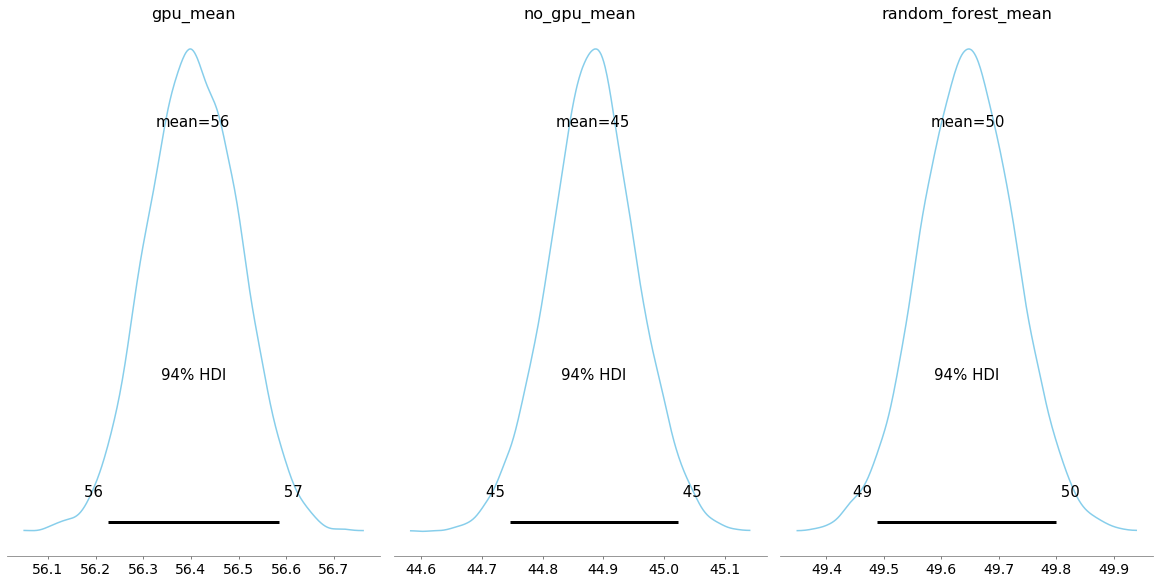

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

μ_m = df_model_comparison.fit_times.mean()
μ_s = df_model_comparison.fit_times.std() * 2

with pm.Model() as model2:
    group1_mean = pm.Normal("gpu_mean", mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal("no_gpu_mean", mu=μ_m, sd=μ_s)
    group3_mean = pm.Normal("random_forest_mean", mu=μ_m, sd=μ_s)
    
    
σ_low = 1
σ_high = 10

with model2:
    group1_std = pm.Uniform("gpu_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("no_gpu_std", lower=σ_low, upper=σ_high)
    group3_std = pm.Uniform("random_forest_std", lower=σ_low, upper=σ_high)
    
    
with model2:
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

pm.plot_kde(np.random.exponential(30, size=10000), fill_kwargs={"alpha": 0.5});


y1 = np.array(df_model_comparison[df_model_comparison.title == "gpu"].fit_times)
y2 = np.array(df_model_comparison[df_model_comparison.title == "no_gpu"].fit_times)
y3 = np.array(df_model_comparison[df_model_comparison.title == "random_forest"].fit_times)
with model2:
    lam1 = group1_std ** -2
    lam2 = group2_std ** -2
    lam3 = group3_std ** -2
    
    group1 = pm.StudentT("gpu", nu=ν, mu=group1_mean, lam=lam1, observed=y1)
    group2 = pm.StudentT("no_gpu", nu=ν, mu=group2_mean, lam=lam2, observed=y2)
    group3 = pm.StudentT("random_forest", nu=ν, mu=group3_mean, lam=lam3, observed=y3)
    
    
with model2:
    trace = pm.sample(2000)
    
pm.plot_posterior(
    trace,
    var_names=["gpu_mean", "no_gpu_mean","random_forest_mean"],
    color="#87ceeb",
    figsize=(16,8)
);

In [5]:
df_model_comparison.fit_times.mean()

47.466839704513546